In [1]:
import os 
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

model_name = os.getenv("MODEL_NAME") or "gpt-4o-mini"
model_provider = os.getenv("MODEL_PROVIDER") or "openai"


In [16]:
from typing import Annotated, Literal, TypedDict 
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

@tool
def recommend_recipe(dish: str):
    """주어진 요리에 대한 간단한 레시피를 제공합니다.""" 
    recipes = {
        "파스타": "재료: 스파게티 면, 토마토 소스, 올리브 오일, 마늘. 면을 삶고 소스를 부어주세요.",
        "불고기": "재료: 소고기, 간장, 설탕, 마늘. 고기를 양념에 재워 볶아주세요.",
        "샐러드": "재료: 양상추, 토마토, 오이, 드레싱. 채소를 썰어 드레싱과 버무려주세요."
    }

    return recipes.get(dish, "죄송하지만 해당 요리의 레시피를 찾을 수 없습니다.")

tools = [recommend_recipe]

tool_node = ToolNode(tools)

model = ChatOpenAI(
    model=model_name, 
    temperature=0,
).bind_tools(tools)

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools" 
    return END


def call_model(state: MessagesState) :
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")

checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

In [22]:
final_state = app.invoke(
    {
        "messages": [HumanMessage(content="샐러드 레시피를 알려줘")]
    },
    config={
        "configurable": {"thread_id": 101}
    },
    debug=True
)

final_state["messages"][-1].content

[values] {'messages': [HumanMessage(content='파스타 레시피를 알려줘', additional_kwargs={}, response_metadata={}, id='606c8a7d-1256-4441-8cb5-8493a13c61be'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IXGP2Qeoh0uEljVaCAvcbk5A', 'function': {'arguments': '{"dish":"파스타"}', 'name': 'recommend_recipe'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 59, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9RtyXM094aGQ4eSKZ7F5ZQQHGH6v', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a2d97704-2940-47ac-be0f-3c9a78804dc5-0', tool_calls=[{'name': 'recommend_recipe', 'args': {'dish': '파스타'}, 'id': 'call_IXGP

'샐러드 레시피는 다음과 같습니다:\n\n### 재료\n- 양상추\n- 토마토\n- 오이\n- 드레싱 (올리브 오일, 식초, 소금, 후추 등)\n\n### 조리 방법\n1. 양상추는 깨끗이 씻어 적당한 크기로 찢어주세요.\n2. 토마토와 오이는 먹기 좋은 크기로 썰어주세요.\n3. 모든 채소를 큰 그릇에 담고, 드레싱을 뿌려 잘 버무려주세요.\n4. 원하시면 견과류나 치즈를 추가하여 더욱 풍부한 맛을 즐길 수 있습니다.\n\n신선하고 맛있는 샐러드를 즐기세요!'

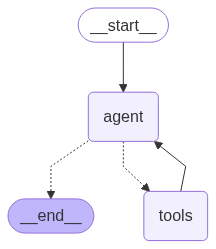

In [20]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [23]:
final_state = app.invoke(
    {
        "messages": [HumanMessage(content="방금 어떤 레시피를 알려주었지?")]
    },
    config={
        "configurable": {"thread_id": 101}
    },
    debug=True
)

final_state["messages"][-1].content

[values] {'messages': [HumanMessage(content='파스타 레시피를 알려줘', additional_kwargs={}, response_metadata={}, id='606c8a7d-1256-4441-8cb5-8493a13c61be'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IXGP2Qeoh0uEljVaCAvcbk5A', 'function': {'arguments': '{"dish":"파스타"}', 'name': 'recommend_recipe'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 59, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C9RtyXM094aGQ4eSKZ7F5ZQQHGH6v', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a2d97704-2940-47ac-be0f-3c9a78804dc5-0', tool_calls=[{'name': 'recommend_recipe', 'args': {'dish': '파스타'}, 'id': 'call_IXGP

'방금 "샐러드" 레시피를 알려드렸습니다. 양상추, 토마토, 오이와 드레싱을 사용하여 간단하게 만들 수 있는 방법이었습니다. 더 궁금한 점이 있으면 말씀해 주세요!'